# Generating Synthetic Wideband Spectrogram-Like Images
In this notebook we will use TorchSig's `image_datasets` module to generate synthetic spectrograms of a few modeled signal types.

---

## Import Libraries

In [21]:
import os
from torchsig.image_datasets.datasets.synthetic_signals import GeneratorFunctionDataset, rectangle_signal_generator_function, tone_generator_function, repeated_signal_generator_function, chirp_generator_function
from torchsig.image_datasets.datasets.file_loading_datasets import SOIExtractorDataset, LazyImageDirectoryDataset
from torchsig.image_datasets.datasets.composites import ConcatDataset
from torchsig.image_datasets.datasets.yolo_datasets import YOLOImageCompositeDataset, YOLODatasetAdapter, YOLODatum
from torchsig.image_datasets.transforms.impairments import BlurTransform, RandomGaussianNoiseTransform, RandomImageResizeTransform, RandomRippleNoiseTransform, ScaleTransform, scale_dynamic_range, normalize_image
from torchsig.image_datasets.plotting.plotting import plot_yolo_boxes_on_image, plot_yolo_datum
from torchsig.image_datasets.datasets.protocols import CFGSignalProtocolDataset, FrequencyHoppingDataset, random_hopping, YOLOFrequencyHoppingDataset, YOLOCFGSignalProtocolDataset

from torchsig.datasets.narrowband import NewNarrowband, StaticNarrowband
from torchsig.utils.writer import DatasetCreator
from torchsig.datasets.dataset_metadata import NarrowbandMetadata
import torchsig.transforms.dataset_transforms as ST
import numpy as np

from torchsig.image_datasets.dataset_generation import batched_write_yolo_synthetic_dataset

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10) #increase the pyplot figure display size in the notebook for better visibility

-----------------------------
## Modeling Signals Using CFGSignalProtocolDataset

A `CFGSignalProtocolDataset` is a dataset meant for modeling complicated relationships between individual components of a larger signal

Here we define two functions: rising_chirp and falling_chirp, which return slanted forward and backwards diagonal lines respectively.
We then combine those two basic components using a CFGSignalProtocolDataset to make a full signal shape.

The CFGSignalProtocolDataset is an implementation of Context Free Grammar (CFG) logic for image datasets, such that each token of a string within the grammar is tied to either a dataset or a generator function which outputs image data. The result is an image composite containing all of the corresponding images side by side in order.
We pass in a single argument to the CFGSignalProtocolDataset which defines it's start token.
We then use the CFGSignalProtocolDataset.add_rule(token_in, token_out | list(token_out_0, token_out_1, ..... etc), relative_frequency) method to add in the logic o four CFG.

Here, we are making a CFG starting on the token 'cfg_signal' and using the following rules:
- `cfg_signal` will always evaluate as one 'rising_or_falling_stream' followed by 12 `rising_falling_or_null'
- `rising_falling_or_null` will half the time evaluate as an empty string (ignored in the output image), and half the time as a 'rising_or_falling_stream'
- `rising_or_falling_stream` will evaluate half the time as a 'rising_stream' and half the time as a `falling_stream`
- `rising_stream` and `falling_stream` evaluate to between one and three `rising_segment` or `falling_segment' respectively
- a `rising_segment` is three `rising_chirp`s 
- a `falling_segment` is three `falling_chirp`s
- 'rising_chirp' and `falling_chirp` are evaluated using the `rising_chirp` and `falling_chirp` functions

The result is fed into a `YOLODatasetAdapter` to return objects of type `YOLODatum` instead of plain images (this will be useful later), and plotted below.

In [4]:
def add_falling_edge(img_tnsr):
    img_tnsr[:,:,-1] = 1
    return img_tnsr

rising_chirp = GeneratorFunctionDataset(chirp_generator_function(1, 20, 4, random_height_scale = [0.9,1.1], random_width_scale = [1,2]), 
                                        transforms=add_falling_edge)
falling_chirp = GeneratorFunctionDataset(chirp_generator_function(1, 20, 4, random_height_scale = [0.9,1.1], random_width_scale = [1,2]), 
                                         transforms=[add_falling_edge, lambda x: x.flip(-1)])

chirp_stream_ds = CFGSignalProtocolDataset('cfg_signal')
chirp_stream_ds.add_rule('cfg_signal', ['rising_or_falling_stream'] + ['rising_falling_or_null']*12)
chirp_stream_ds.add_rule('rising_falling_or_null', 'rising_or_falling_stream', 1)
chirp_stream_ds.add_rule('rising_falling_or_null', 'null', 1)
chirp_stream_ds.add_rule('null', None)
chirp_stream_ds.add_rule('rising_or_falling_stream', 'rising_stream')
chirp_stream_ds.add_rule('rising_or_falling_stream', 'falling_stream')
chirp_stream_ds.add_rule('rising_stream', ['rising_segment'] + ['rising_segment_or_null']*2)
chirp_stream_ds.add_rule('rising_segment_or_null', 'rising_segment')
chirp_stream_ds.add_rule('rising_segment_or_null', 'null')
chirp_stream_ds.add_rule('rising_segment', ['rising_chirp']*3)
chirp_stream_ds.add_rule('rising_chirp', rising_chirp)
chirp_stream_ds.add_rule('falling_stream', ['falling_segment'] + ['falling_segment_or_null']*2)
chirp_stream_ds.add_rule('falling_segment_or_null', 'falling_segment')
chirp_stream_ds.add_rule('falling_segment_or_null', 'null')
chirp_stream_ds.add_rule('falling_segment', ['falling_chirp']*3)
chirp_stream_ds.add_rule('falling_chirp', falling_chirp)

yolo_chirp_stream_ds = YOLODatasetAdapter(chirp_stream_ds, class_id=0)

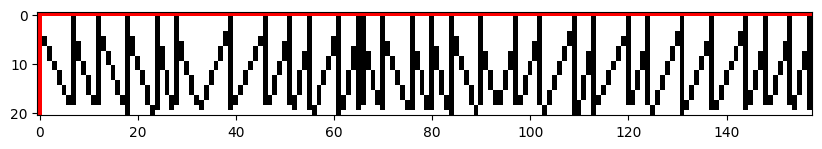

In [5]:
plot_yolo_datum(yolo_chirp_stream_ds[0])

-----------------------------
Another kind of signal modeled using `CFGSignalProtocolDataset`, consisting of a fixed start and end sequence with between one and four 'bytes' of either large or small lines in the middle

In [6]:
big_chirp_fn = chirp_generator_function(2, 8, 2, random_height_scale = [0.8,1.2], random_width_scale = [0.5,2])
small_chirp_fn = chirp_generator_function(2, 4, 2, random_height_scale = [0.8,1.2], random_width_scale = [0.5,2])
init_chirp_fn = chirp_generator_function(4, 2, 3, random_height_scale = [0.8,1.2], random_width_scale = [0.8,1.2])
exit_chirp_fn = chirp_generator_function(2, 2, 2, random_height_scale = [0.8,1.2], random_width_scale = [0.8,1.2])

bytes_ds = CFGSignalProtocolDataset('cfg_signal')
bytes_ds.add_rule('cfg_signal', ['init_chirp', 'main_signal', 'exit_signal'])
bytes_ds.add_rule('main_signal_chirp', ['bit_chirp']*8)
bytes_ds.add_rule('bit_chirp', big_chirp_fn)
bytes_ds.add_rule('bit_chirp', small_chirp_fn)
bytes_ds.add_rule('main_signal', (['main_signal_chirp_or_null']*3)+['main_signal_chirp'])
bytes_ds.add_rule('main_signal_chirp_or_null', 'main_signal_chirp', 1)
bytes_ds.add_rule('main_signal_chirp_or_null', 'null', 1)
bytes_ds.add_rule('null', None)
bytes_ds.add_rule('init_chirp', init_chirp_fn)
bytes_ds.add_rule('exit_signal', [exit_chirp_fn, exit_chirp_fn, exit_chirp_fn])

yolo_bytes_ds = YOLODatasetAdapter(bytes_ds, class_id=0)

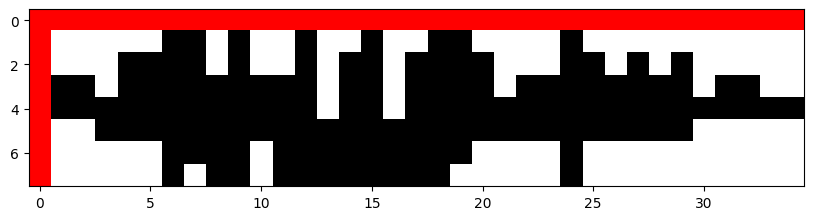

In [7]:
plot_yolo_datum(yolo_bytes_ds[0])

-----------------------------
## Modeling Signal Hopping using YOLOFrequencyHoppingDataset

A `YOLOFrequencyHoppingDataset` is a dataset meant for modeling channel hops. it is passed a nmber of channels and a channel size (in pixels), and a max and min number of bursts to send.
It will then generate images simulating a series of bursts along different channels.
A hopping_function can be passed in, which determines the order in which channels are selected. By default they are selected in either ascending or descending order (randomly with 50/50 odds).

Here we define two `YOLOFrequencyHoppingDataset` objects, both using bursts from the bytes_ds we defined above, but one hopping in linear order, and the other hopping randomly.

We then define a YOLOCFGSignalProtocolDataset which combines them and returns one, the other, or both in either order.

`YOLOCFGSignalProtocolDataset` works just like `CFGSignalProtocolDataset` above, except that the data it handles are of type `YOLODatum` and not images alone. This is done to track internally where the bounding box around each signal burst should go.

In [8]:
hopper_ds = YOLOFrequencyHoppingDataset(yolo_bytes_ds, [20,80], 10, [100,100], [4,8])
random_hopper_ds = YOLOFrequencyHoppingDataset(yolo_bytes_ds, [20,80], 10, [100,100], [4,8], hopping_function=random_hopping)

two_mode_hopper = YOLOCFGSignalProtocolDataset('two_mode_hopping')
two_mode_hopper.add_rule('two_mode_hopping',['12'])
two_mode_hopper.add_rule('two_mode_hopping',['21'])
two_mode_hopper.add_rule('two_mode_hopping',['1'])
two_mode_hopper.add_rule('two_mode_hopping',['2'])
two_mode_hopper.add_rule('12',['1','2'])
two_mode_hopper.add_rule('21',['2','1'])
two_mode_hopper.add_rule('1',hopper_ds)
two_mode_hopper.add_rule('2',random_hopper_ds)

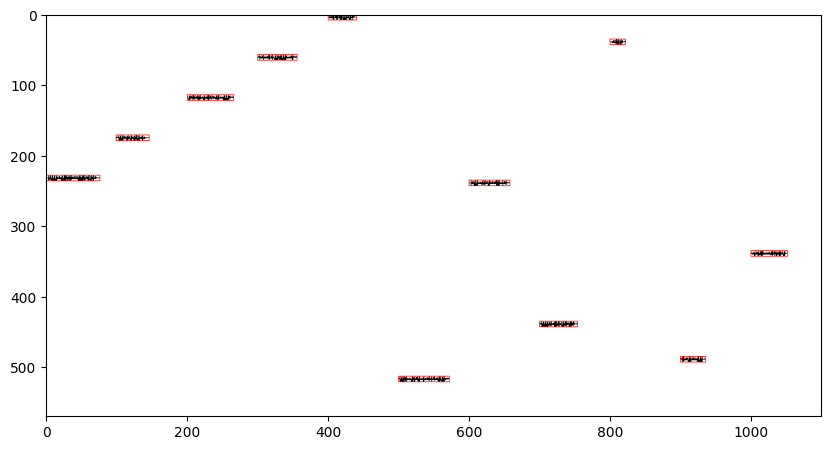

In [9]:
plot_yolo_datum(two_mode_hopper[0])

-----------------------------
## Using Torchsig Narrrowband Datasets in Images

Here we create a `ModulationsDataset` with a `SpectrogramImage` transform to make it return images of the generated data.

This dataset is then passed into a `GeneratorFunctionDataset` with some filtering functions to clear the edges of the generated images.
We also add some transforms to randomly resize andslightly blur the result. These are useful for image compositing.

`GeneratorFunctionDataset` can take any zero-argument function which returns images and treat it as an image dataset.

In [64]:
def threshold_mod_signal(signal):#quick function for cleaning up narrowband spectrogram to look neat in composites; not strictly necessary, but very useful
    signal[signal**4<0.02] = 0
    return signal[:,:,5:-5] # cuts off the ends to look more seemless in composites

mod_ds_transform = [
    ST.Spectrogram(fft_size=128)
]


md = NarrowbandMetadata(
    num_iq_samples_dataset = 2*128**2,
    fft_size = 128,
    impairment_level = 0,
    num_samples = 10,
    transforms = mod_ds_transform
)
ds = NewNarrowband(
    dataset_metadata = md
)

dc = DatasetCreator(
    dataset = ds,
    root = "./datasets/synthetic_spectrogram_example",
    overwrite = True
)
dc.create()

mod_ds = StaticNarrowband(
    root = "./datasets/synthetic_spectrogram_example",
    impaired = False
)

signal_transforms = []
signal_transforms += [normalize_image]
signal_transforms += [RandomImageResizeTransform([0.02,1.5])]
signal_transforms += [BlurTransform(strength=0.5, blur_shape=(5,1))]
signal_transforms += [threshold_mod_signal]
signal_transforms += [BlurTransform(strength=1, blur_shape=(5,1))]


mod_spec_dataset = GeneratorFunctionDataset(lambda : 1 - mod_ds[np.random.randint(len(mod_ds))][0][None, :, :], transforms=signal_transforms)

Generating Narrowband: 100%|██████████| 10/10 [00:00<00:00, 13.80it/s]


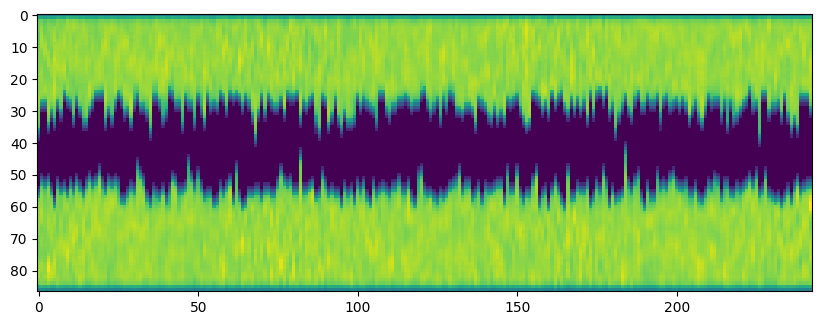

In [65]:
plt.imshow(mod_spec_dataset[0][0])

-----------------------------
## Using YOLOImageCompositeDataset to put everything together

Here we create a `YOLOImageCompositeDataset` which combines all of the datasets above into large composite simulated wideband spectrogram images.

`YOLOImageCompositeDataset` takes as input a spectrogram_size, and has nothing in it at creation.
Components must be added using `YOLOImageCompositeDataset.add_component(dataset, min_to_add, max_to_add)`.
Every component will be added a uniform random number of times to the composites according to `min_to_add` and `max_to_add`.
Components can be assigned a `class_id`, which will be the class id of the resulting `YOLODatum`, or they can be set to `use_source_yolo_labels`, in which case the composite will add in any yolo data that is retreaved from the component dataset. Components with no class_id will be added to the image, but unlabeled, and treated as background.

Here we are adding the `yolo_chirp_stream_ds`, `bytes_ds`, `two_mode_hopper`, and `mod_spec_dataset` defined above to our `YOLOImageCompositeDataset` to simulate wideband data from an RF environment with many different types of transmitter present.

In [66]:
def clamp_max_by_std(signal): # used to limit the dynamic range of the resulting image; stops overlapping image components from looking too dark or throwing off the rest of the image
    signal[signal > signal.mean() + signal.std()*3] = signal.mean() + signal.std()*3
    return signal

spectrogram_size = (1,1024,1024)

two_mode_hopper.transforms = [lambda x: YOLODatum(BlurTransform(strength=1, blur_shape=(5,1))(x.img), x.labels)] # add a little extra blur to help blend with the composite
composite_transforms = []
composite_transforms += [clamp_max_by_std] # limit dynamic range due to overlapping signals
composite_transforms += [normalize_image] # inf norm
composite_transforms += [RandomGaussianNoiseTransform(mean=0, range=(0.2,0.8))] # add background noise
composite_transforms += [scale_dynamic_range]
composite_transforms += [normalize_image] # inf norm
composite_spectrogram_dataset = YOLOImageCompositeDataset(spectrogram_size, transforms=composite_transforms, dataset_size=250000, max_add=True)
composite_spectrogram_dataset.add_component(yolo_chirp_stream_ds, min_to_add=0, max_to_add=3, use_source_yolo_labels=True)
composite_spectrogram_dataset.add_component(bytes_ds, min_to_add=0, max_to_add=3, class_id=0)
composite_spectrogram_dataset.add_component(two_mode_hopper, min_to_add=0, max_to_add=1, use_source_yolo_labels=True)
composite_spectrogram_dataset.add_component(mod_spec_dataset, min_to_add=1, max_to_add=3, class_id=0)

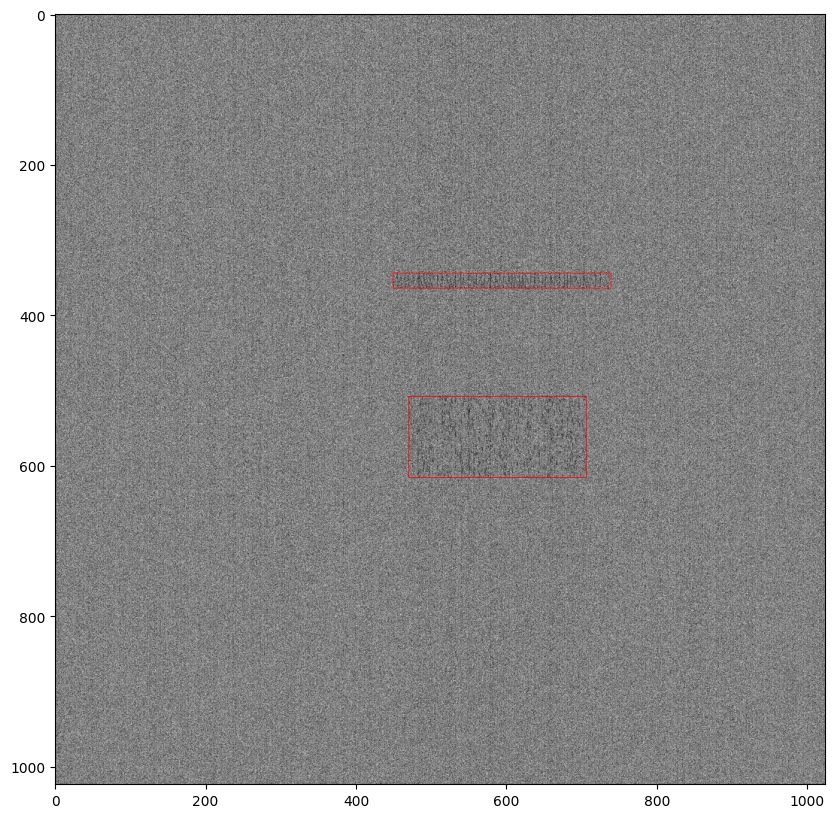

In [67]:
sample_datum = composite_spectrogram_dataset[0]
plot_yolo_datum(sample_datum)

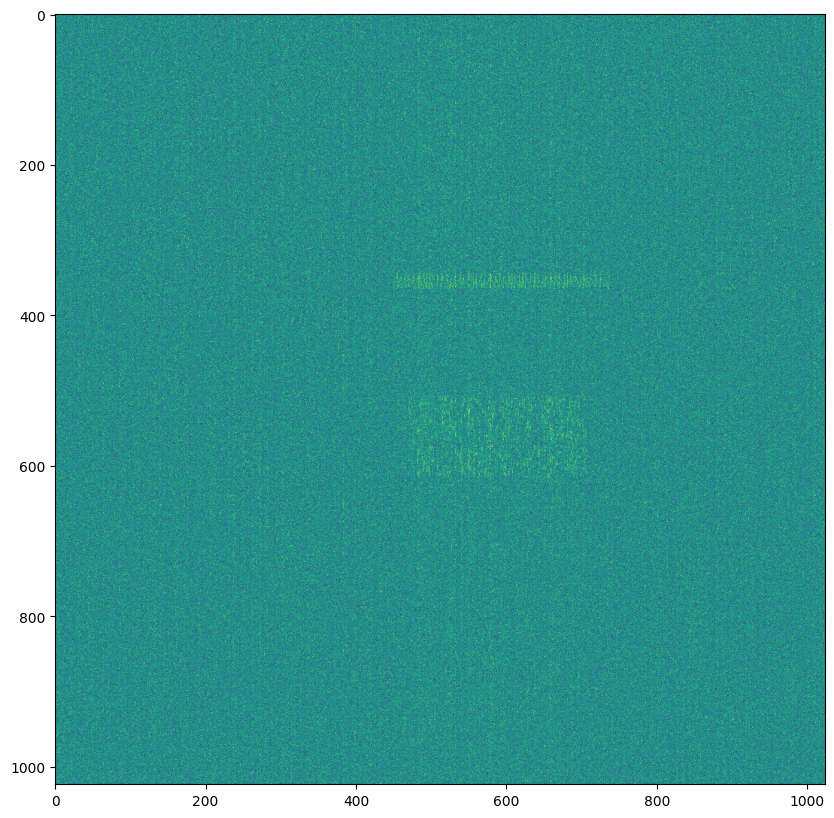

In [68]:
plt.imshow(sample_datum[0][0])